# Model Optimization

##### **1. Objectives**

Design two optimization experiments:

*   **Exp1 – EDA-driven feature engineering:** Validate targeted transforms and quantify feature contributions using explainable ML.
*   **Exp2 – Model ensembling:** Leverage complementary inductive biases to improve accuracy beyond single models.

---

##### **2. Optimization Results**

**Exp1 — Feature Engineering + Explainability**

| Component | Details |
| :--- | :--- |
| **Pipeline** | 1. **Feature pruning:** Drop very low Spearman-correlation features.<br>2. **Target log transform:** Train on ''log(y)'', back-transform with ''exp(·)''.<br>3. **Time recast:**<br>   • ''house_age = 2024-06 − year_built''<br>   • ''months_since_ref = src_month − 2024-06'' |
| **Outcome** | Test RMSE: **93,998.18**<br>Change vs. Baseline (94,052.25): **-54.07 (≈ -0.06%)**  |
| **Analysis** | No significant improvement. |

**Exp2 — Stacking Ensemble**

| Component | Details |
| :--- | :--- |
| **Pipeline** | 1. Retain all features; reuse baseline preprocessing.<br>2. Train diverse **base learners** (linear + tree models).<br>3. Use **Lasso** meta-learner on out-of-fold predictions. |
| **Outcome** | Test RMSE: **92,887.82**<br>• vs. Baseline: **-1,164.43 (-1.24%)**<br>• vs. Exp1: **-1,110.36 (-1.18%)** |
| **Interpretation** | Ensemble exploits complementary strengths (linear + tree), yielding **meaningful, consistent improvement**. |

---

##### **3. In terms of model optimization, why do traditional feature-engineering methods often fail when applied to complex data structures and large-scale datasets?**
Analysis of the underlying causes based on this experiment:

Ineffectiveness of Low-Correlation Feature Removal:
With a large dataset (n = 125,163 samples) and a moderate number of features (p = 55), the sample-to-feature ratio (n/p ≈ 2,275) is very high. Consequently, the model is not prone to overfitting, and removing low-correlation features offers minimal benefit.

Explainability analysis (SHAP values) from the XGBoost model revealed that features with near-zero linear correlation can still have significant predictive power through non-linear interactions. For instance, global_economic_index had a Spearman correlation of 0.00 but a SHAP value of 1,512.24, indicating its importance to the model.

Minimal Impact of Temporal Features:
The newly created temporal features only marginally increased the feature importance of year_built (from the 6th to the 5th most important feature) and did not provide a substantial boost to the overall model accuracy.

This experiment highlights a key limitation of traditional feature engineering on large-scale, complex datasets where intricate, non-linear relationships dominate. Stacking ensembles are often more effective than manual feature engineering.

In [8]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from matplotlib.ticker import ScalarFormatter
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb


# Import from src
from src.data_display import df_display
from src.data_processing import check_missing_data,near_zero_var, compute_vif_table
from src.plot import plot_categorical, plot_time_series, plot_numeric, plot_boxplots
from src.pipeline_design import evaluate_model,ridge_pipe,elasticnet_pipe,lasso_pipe,svr_rbf_gscv,linear_svr_gscv,xgb_pipe,CustomPreprocessor


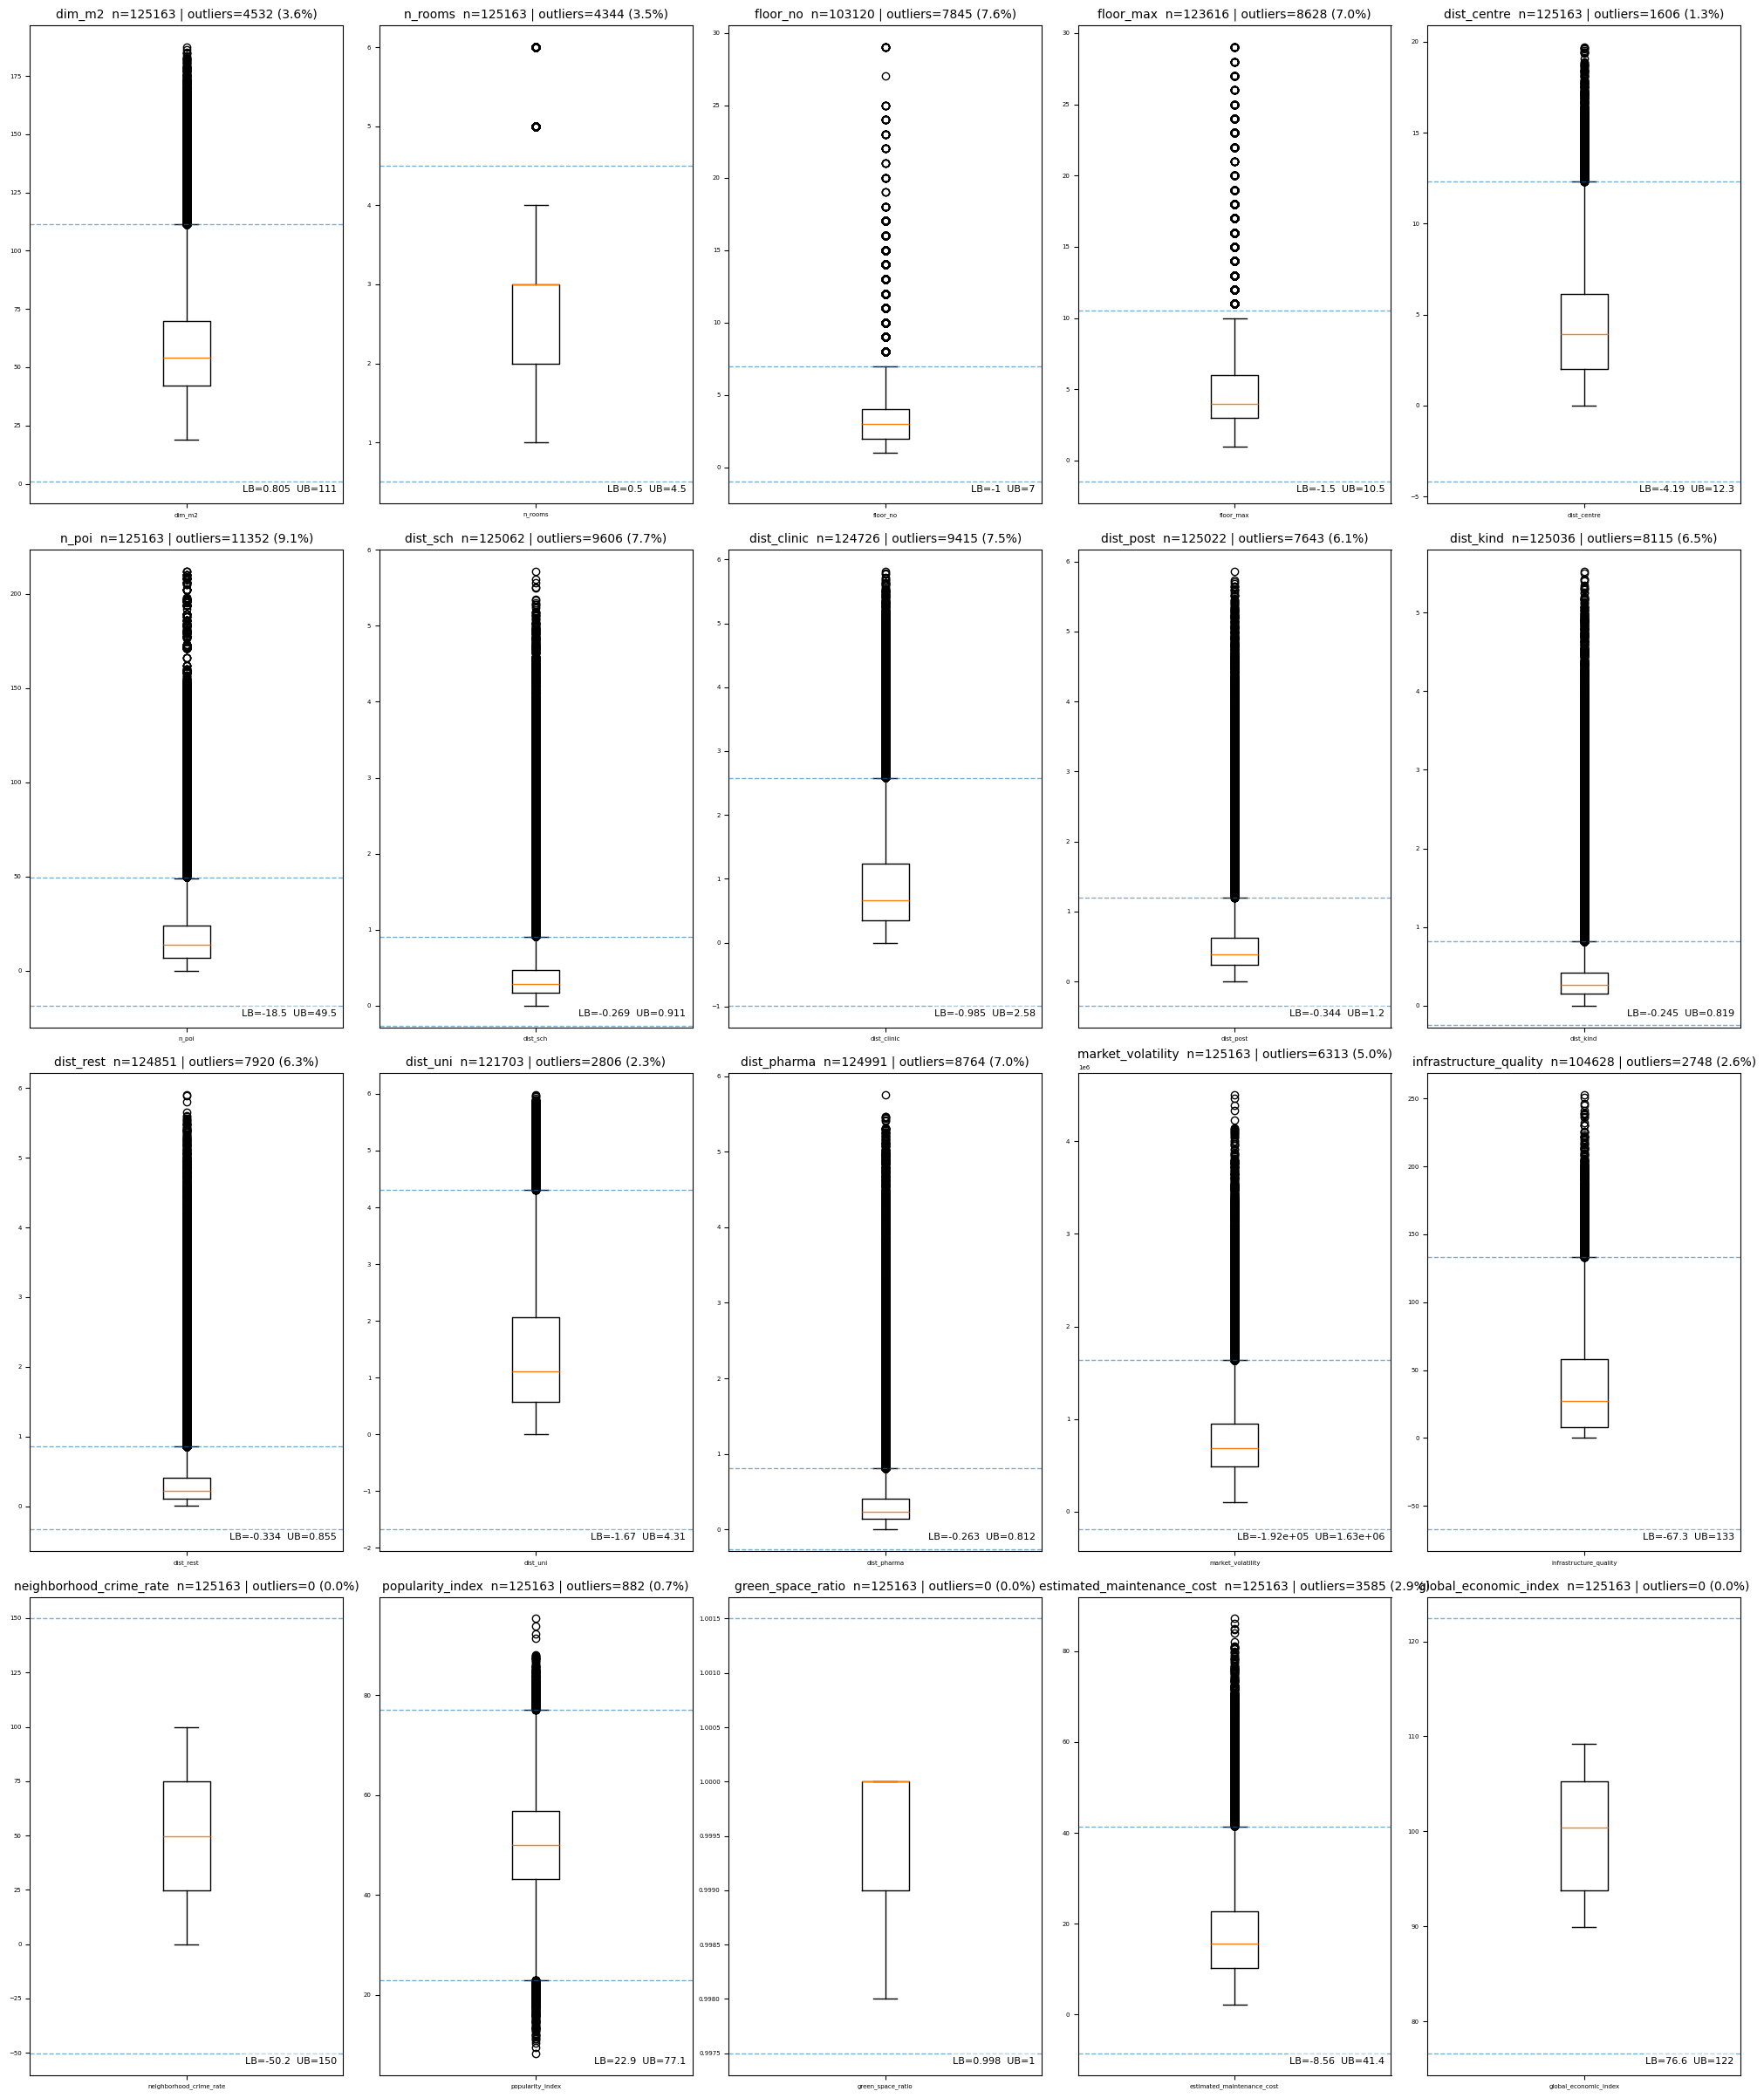

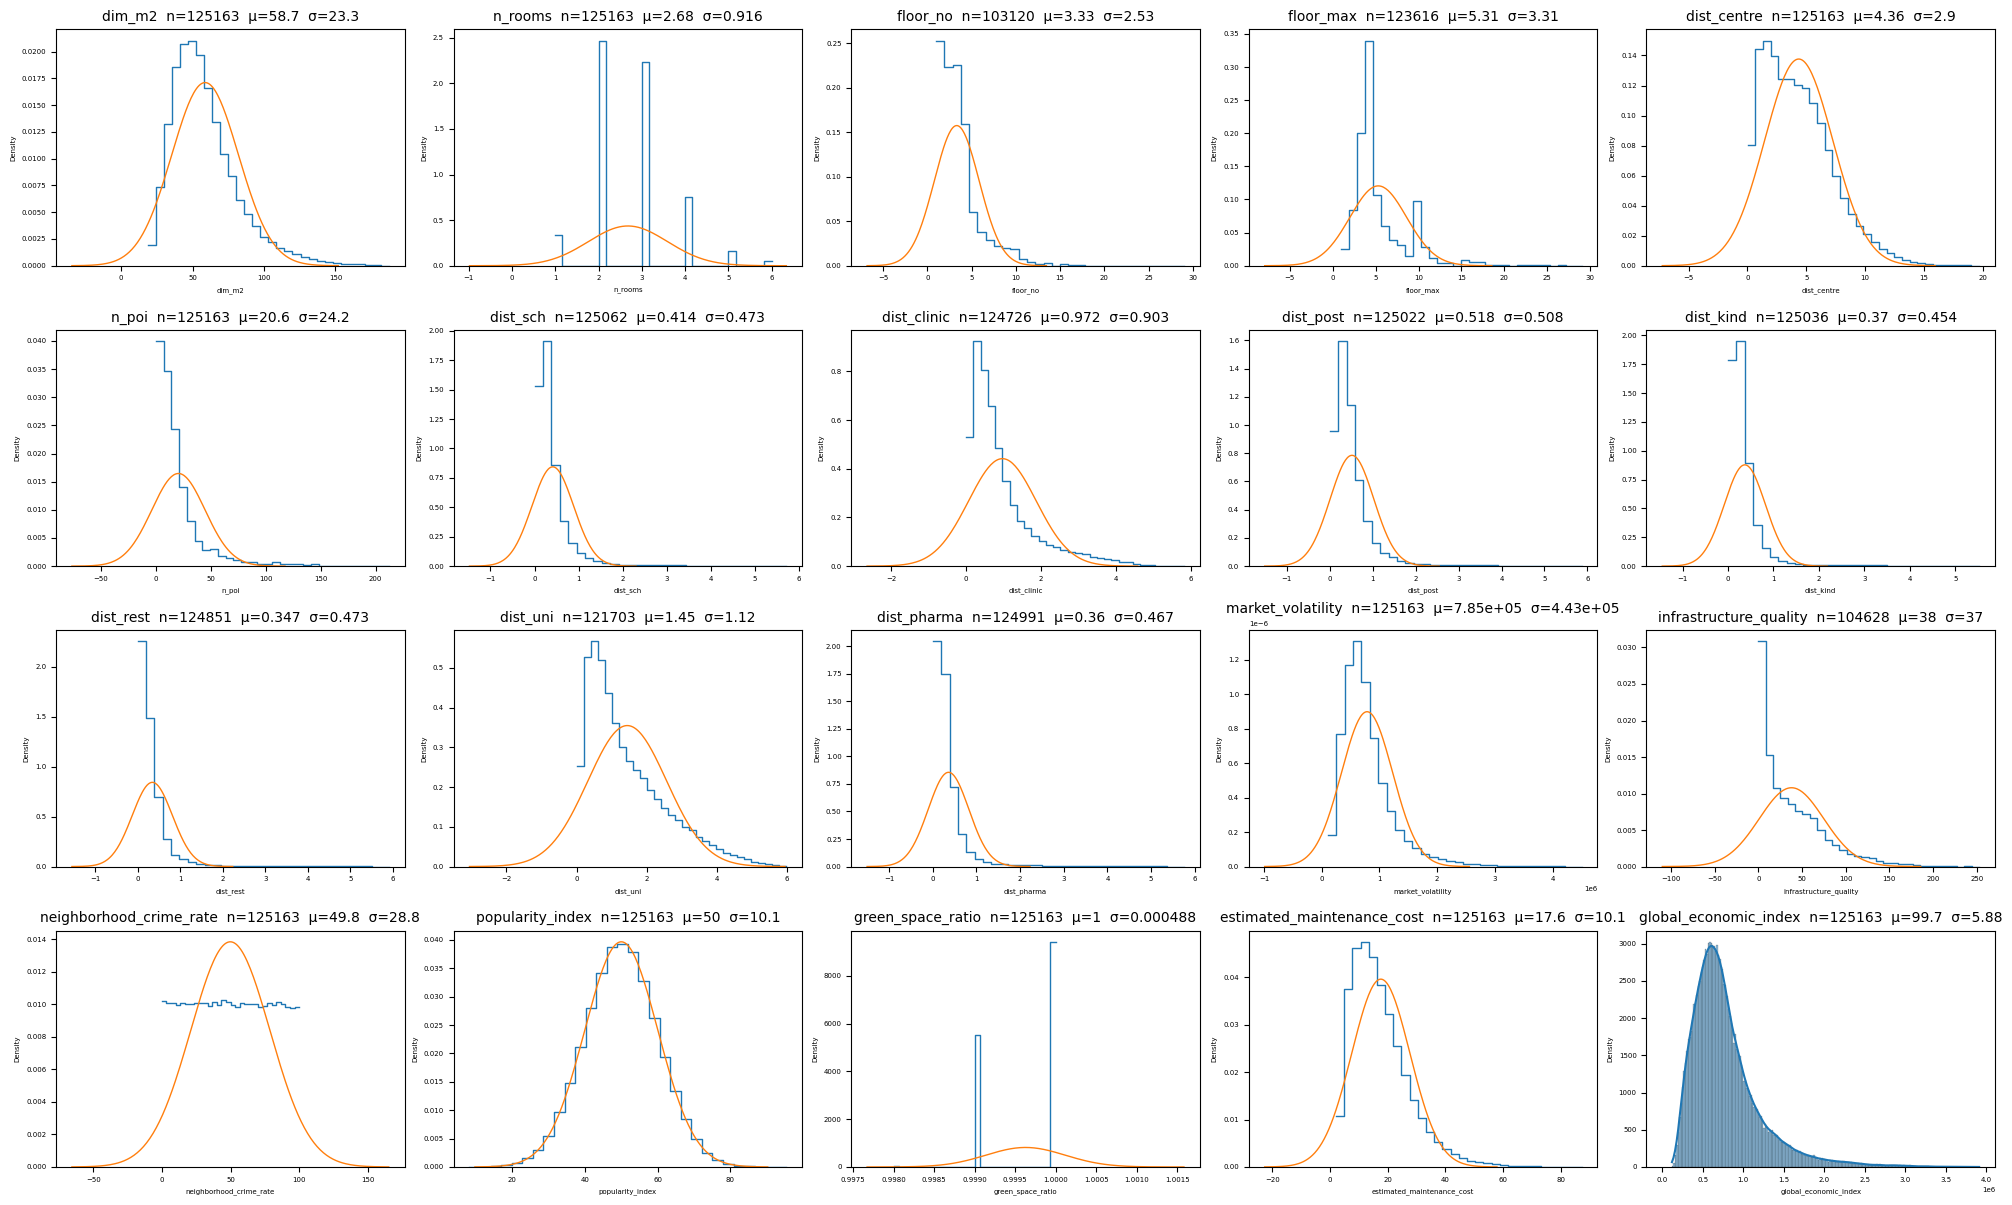

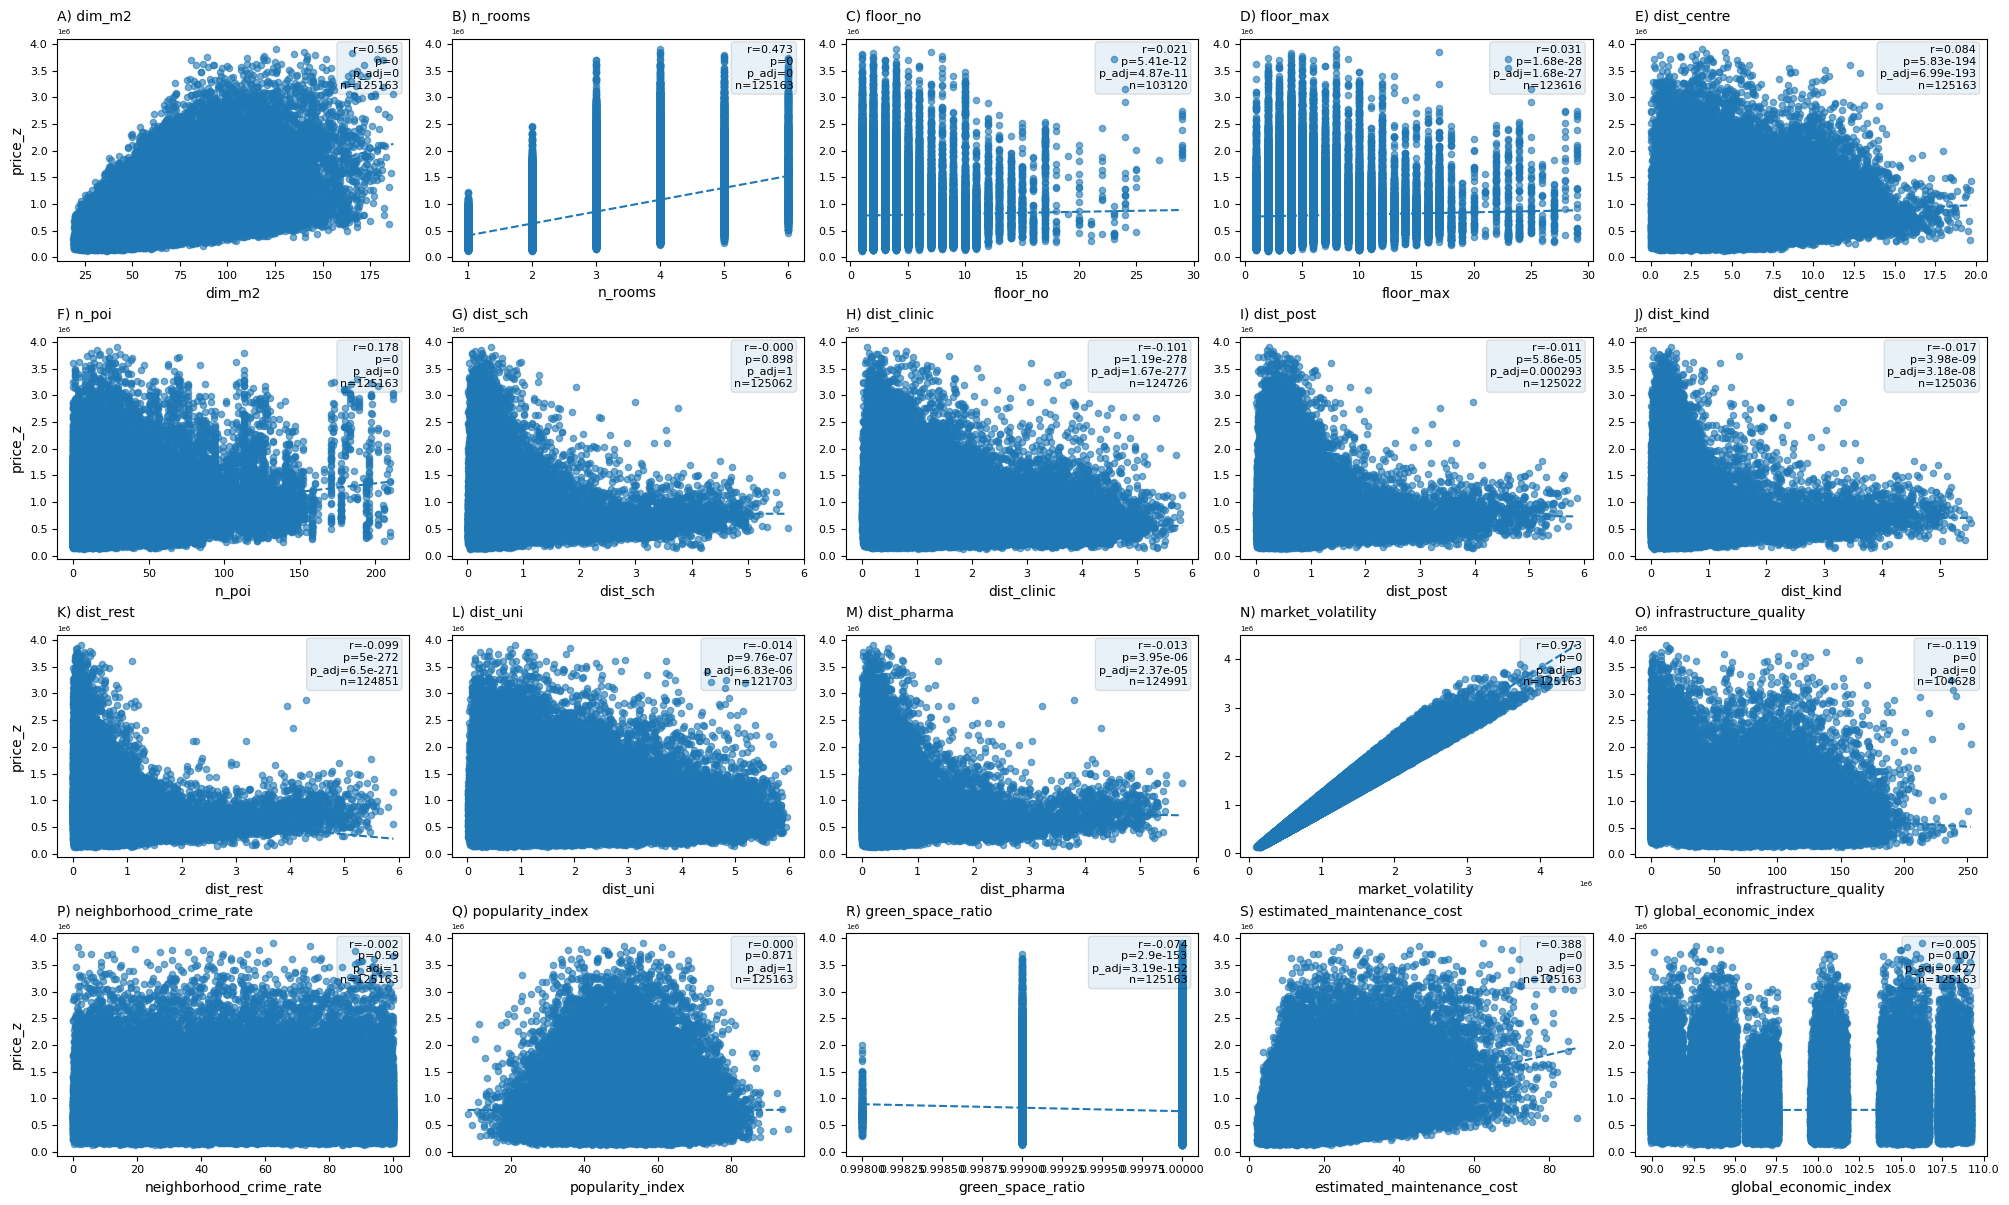

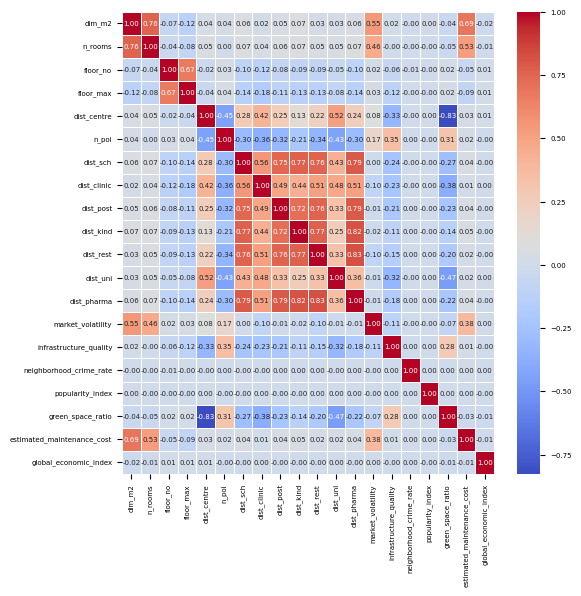

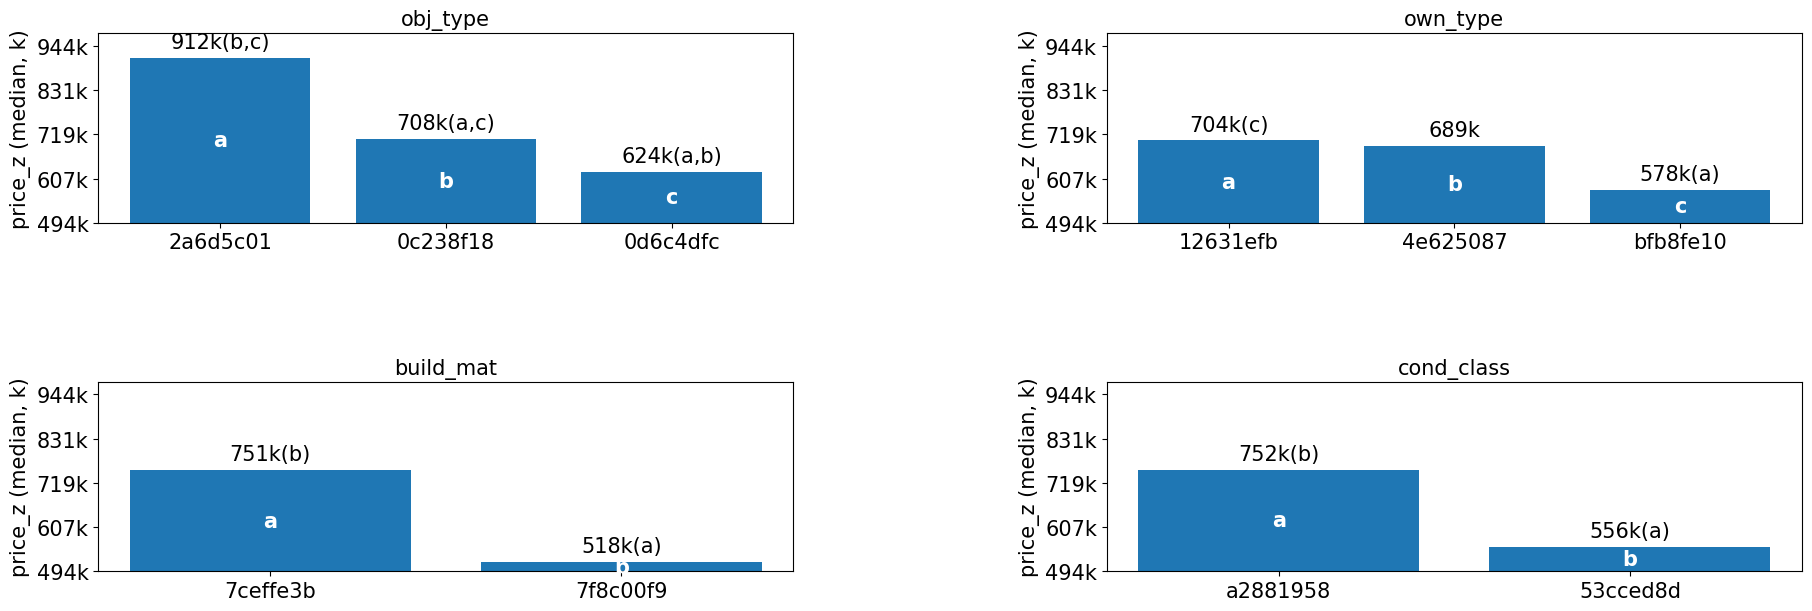

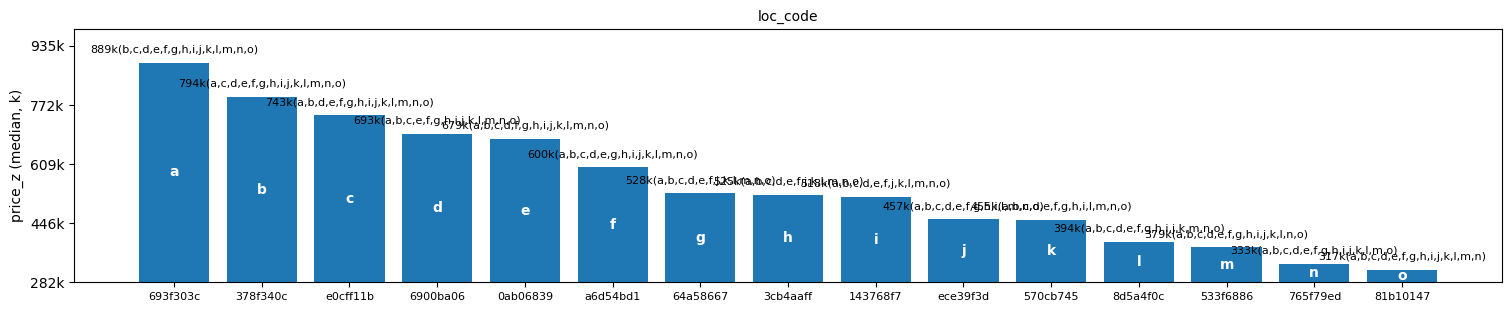

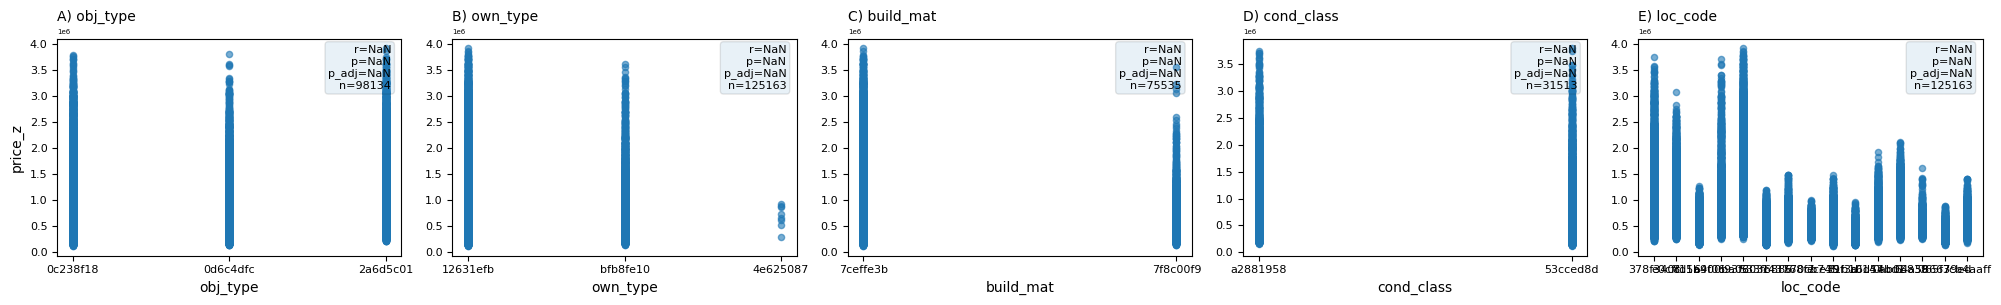

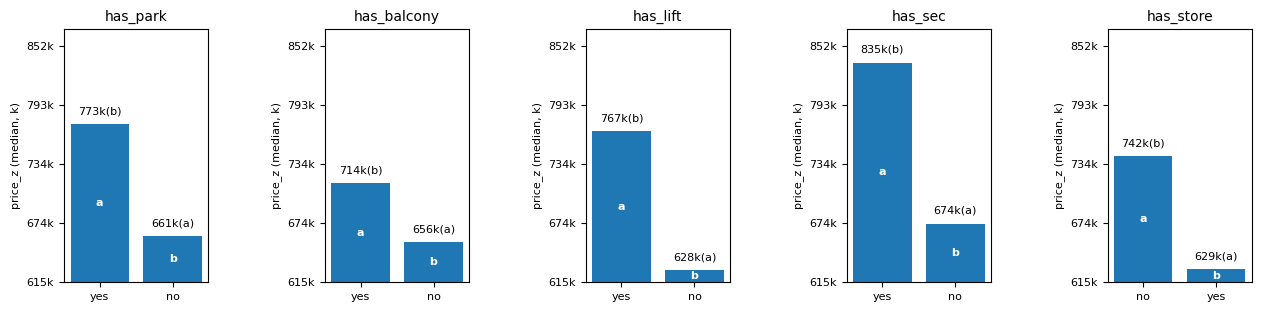

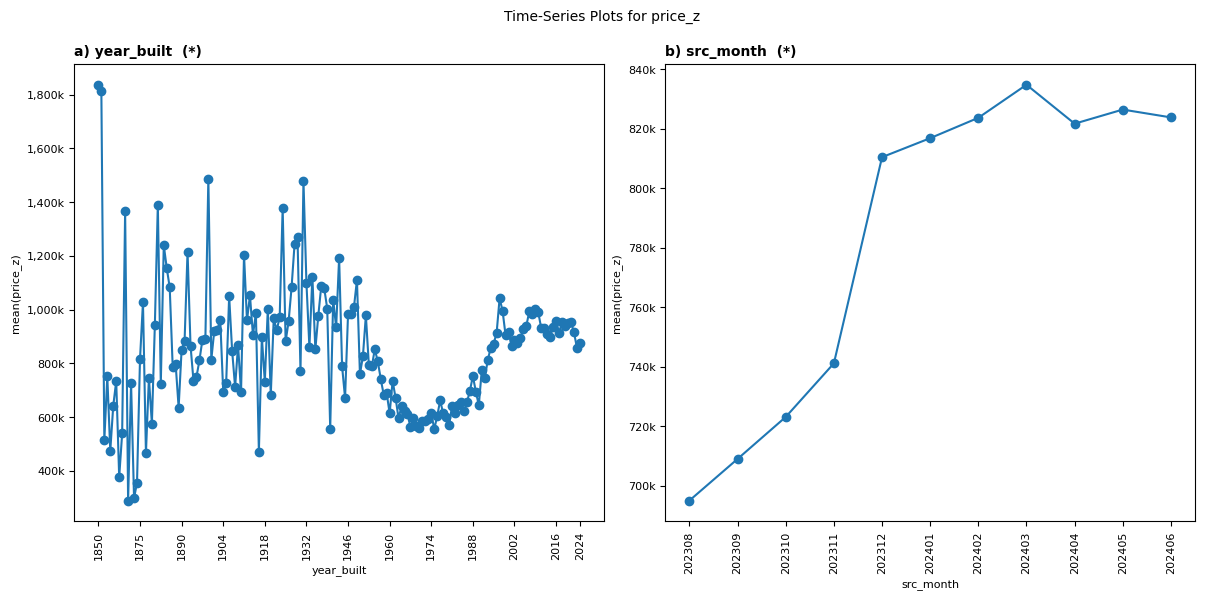

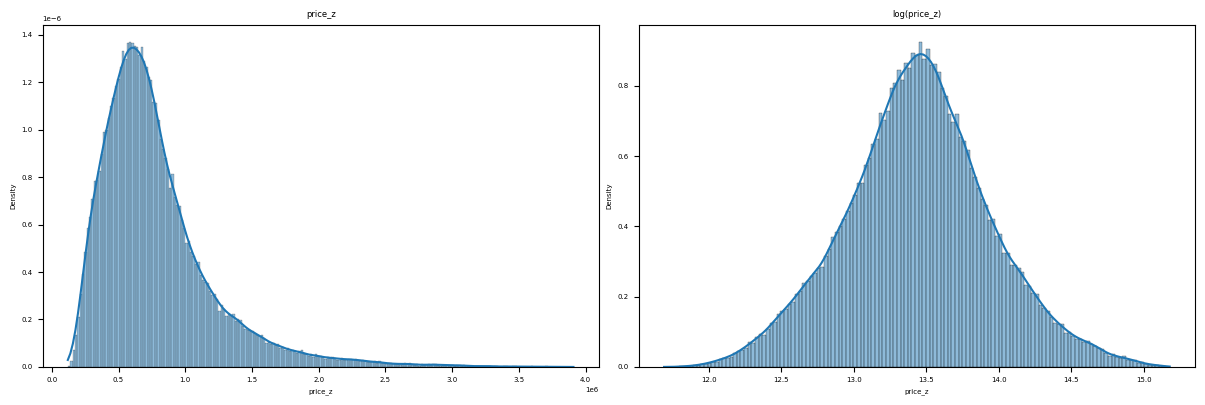

market_volatility             0.97
dim_m2                        0.51
n_rooms                       0.45
estimated_maintenance_cost    0.33
infrastructure_quality       -0.22
dist_rest                    -0.16
green_space_ratio            -0.13
dist_centre                   0.13
dist_clinic                  -0.12
n_poi                         0.10
dist_sch                      0.06
floor_max                     0.05
dist_post                     0.02
dist_uni                      0.01
dist_pharma                   0.01
floor_no                     -0.01
global_economic_index         0.00
neighborhood_crime_rate      -0.00
dist_kind                    -0.00
popularity_index             -0.00
dtype: float64


In [9]:
# --- Execute the data exploration notebook to load data ---
%run "01_Data_Exploration.ipynb"

# 1 Feature Engineering

## 1. Feature Pruning

In [11]:
# Import data
df_train, df_test = train_test_split(
    apartments_train,
    test_size=0.2,        
    random_state=476677,     
    shuffle=True
)

In [12]:
# Remove numeric variables with the lowest correlation to the target ('price_z')
low_corr_feats = corr_with_pricez_sorted.abs()[corr_with_pricez_sorted.abs() < 0.1].index.tolist()
print(low_corr_feats)

['dist_sch', 'floor_max', 'dist_post', 'dist_uni', 'dist_pharma', 'floor_no', 'global_economic_index', 'neighborhood_crime_rate', 'dist_kind', 'popularity_index']


In [13]:
# Candidate numeric features before pruning
numeric = ['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post', 'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'market_volatility', 'infrastructure_quality', 'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio', 'estimated_maintenance_cost', 'global_economic_index']

# Drop features identified as weakly correlated with 'price_z'
numeric = [var for var in numeric if var not in low_corr_feats]

# Other features
categorical = ['obj_type', 'own_type', 'build_mat', 'cond_class', 'loc_code']
boolean = ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']
datetime = ['src_month','year_built']

## 2. Target Log Transform

In [29]:
# Define the target variable column name
target = 'price_z'
drop_cols = low_corr_feats + ['price_z']

# Create feature set by removing low-correlation columns from training data, 
# and apply log transformation to the target variable for training
x_train_fe, y_train_fe = df_train.drop(columns = drop_cols), np.log(df_train[target])

# Create test feature set by removing target column only (keeping all original features)
x_test,  y_test  = df_test.drop(columns = drop_cols),  df_test[target]

In [30]:
numeric

['dim_m2',
 'n_rooms',
 'dist_centre',
 'n_poi',
 'dist_clinic',
 'dist_rest',
 'market_volatility',
 'infrastructure_quality',
 'green_space_ratio',
 'estimated_maintenance_cost']

## 3. Time Features

In [31]:
# 1) Parsing: handle src_month stored as float64 in YYYYMM format (e.g., 202311.0)
class DateParseAndCastTransformer(BaseEstimator, TransformerMixin):
    """
    Parse/cast time-related columns in a DataFrame.
    - src_month: float(YYYYMM) -> datetime64[ns] (set to first day of the month)
    - year_built: -> pandas nullable Int64 (preserve <NA>)
    """
    def __init__(self, errors: str = 'coerce'):
        self.errors = errors

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = _ensure_df(X).copy()

        if 'src_month' in X.columns:
            # Safely convert float64 YYYYMM to int, then parse with '%Y%m'
            s = pd.to_numeric(X['src_month'], errors='coerce')
            mask = s.notna()
            # Use round() to prevent floating point tail issues like 202311.0000001
            s_int = s[mask].round().astype('int64')
            X.loc[:, 'src_month'] = pd.NaT  # Initialize with NaT
            X.loc[mask, 'src_month'] = pd.to_datetime(
                s_int.astype(str), format='%Y%m', errors=self.errors
            )

        if 'year_built' in X.columns:
            # Convert to pandas nullable Int64, keeping <NA>
            X['year_built'] = pd.to_numeric(X['year_built'], errors="coerce").astype("Int64")

        return X


# 2) Feature engineering: calculate building age & month difference
class TimeFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Create time-based features from `year_built` and `src_month`.
    """
    def __init__(self, ref_year: int = 2024, ref_month: int = 6):
        self.ref_year = ref_year
        self.ref_month = ref_month

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = _ensure_df(X).copy()

        if 'year_built' in X.columns:
            # year_built (Int64, possibly with <NA>) -> building age
            # Keep as float to avoid conversion to object in downstream processing
            X['year_built'] = (self.ref_year - X['year_built']).astype('Float64')

        if 'src_month' in X.columns:
            dt = X['src_month']
            # NaT will produce NaN in .dt.year/.dt.month, so months_diff will also be NaN
            yr = dt.dt.year
            mo = dt.dt.month
            months_diff = (self.ref_year - yr) * 12 + (self.ref_month - mo)
            X['src_month'] = months_diff.astype('Float64')

        return X


def _ensure_df(X):
    """Ensure the input is a DataFrame."""
    if isinstance(X, pd.DataFrame):
        return X
    return pd.DataFrame(X)

In [32]:
# 4) Pipeline
time_pipeline = Pipeline(steps=[
    ('parse_and_cast', DateParseAndCastTransformer(errors='coerce')),
    ('time_features', TimeFeatureTransformer(ref_year=2024, ref_month=6))
])

## 4. Model Training

In [33]:
preprocess_pipe = Pipeline([
    ("prep", CustomPreprocessor(    
        numeric=numeric,           
        categorical=categorical,  
        boolean=boolean,          
        date_col='src_month',     
        year_col='year_built' )),
    ("time", time_pipeline),
])

In [34]:
# Apply preprocessing to the training data and fit the preprocessing model
x_train_fe = preprocess_pipe.fit_transform(x_train_fe, y_train_fe)

# Apply the same preprocessing steps to the test data (without refitting)
x_test = preprocess_pipe.transform(x_test)

# Train the XGBoost pipeline using the preprocessed training data
model_fe = xgb_pipe.fit(x_train_fe, y_train_fe)

# Make predictions on the preprocessed test data
y_pred = model_fe.predict(x_test)

C:\Users\JasmineJiang\AppData\Local\Temp\ipykernel_13648\1660848251.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[:, 'src_month'] = pd.NaT  # Initialize with NaT
C:\Users\JasmineJiang\AppData\Local\Temp\ipykernel_13648\1660848251.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[:, 'src_month'] = pd.NaT  # Initialize with NaT


In [35]:
x_train_fe.columns

Index(['dim_m2', 'n_rooms', 'year_built', 'dist_centre', 'n_poi',
       'dist_clinic', 'dist_rest', 'has_park', 'has_balcony', 'has_lift',
       'has_sec', 'has_store', 'src_month', 'market_volatility',
       'infrastructure_quality', 'green_space_ratio',
       'estimated_maintenance_cost', 'obj_type_0c238f18', 'obj_type_0d6c4dfc',
       'obj_type_2a6d5c01', 'obj_type_missing', 'own_type_12631efb',
       'own_type_4e625087', 'own_type_bfb8fe10', 'build_mat_7ceffe3b',
       'build_mat_7f8c00f9', 'build_mat_missing', 'cond_class_53cced8d',
       'cond_class_a2881958', 'cond_class_missing', 'loc_code_0ab06839',
       'loc_code_143768f7', 'loc_code_378f340c', 'loc_code_3cb4aaff',
       'loc_code_533f6886', 'loc_code_570cb745', 'loc_code_64a58667',
       'loc_code_6900ba06', 'loc_code_693f303c', 'loc_code_765f79ed',
       'loc_code_81b10147', 'loc_code_8d5a4f0c', 'loc_code_a6d54bd1',
       'loc_code_e0cff11b', 'loc_code_ece39f3d'],
      dtype='object')

In [36]:
check_missing_data(x_train_fe)

,dtype,count,missing,missing_%


In [37]:
x_train_fe.dtypes

dim_m2                        float64
n_rooms                       float64
year_built                    Float64
dist_centre                   float64
n_poi                         float64
dist_clinic                   float64
dist_rest                     float64
has_park                         int8
has_balcony                      int8
has_lift                         int8
has_sec                          int8
has_store                        int8
src_month                     Float64
market_volatility             float64
infrastructure_quality        float64
green_space_ratio             float64
estimated_maintenance_cost    float64
obj_type_0c238f18               int32
obj_type_0d6c4dfc               int32
obj_type_2a6d5c01               int32
obj_type_missing                int32
own_type_12631efb               int32
own_type_4e625087               int32
own_type_bfb8fe10               int32
build_mat_7ceffe3b              int32
build_mat_7f8c00f9              int32
build_mat_mi

In [38]:
# Revert
y_log_reverted = np.exp(y_pred)

# Calculate Root Mean Squared Error (RMSE) for the reverted log predictions
rmse = mean_squared_error(y_test, y_log_reverted, squared=False)
print("After Feature Engineering RMSE on test set:", rmse)

After Feature Engineering RMSE on test set: 93998.17562384017


d:\Anaconda\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 5. SHAP Analysis

In [39]:
# Import SHAP library for model interpretation
import shap

# Extract the trained XGBoost model from the pipeline
xgb_model_fe = model_fe.named_steps["xgb_reg"]

# Initialize TreeExplainer for XGBoost model interpretation
explainer = shap.TreeExplainer(xgb_model_fe)

# Calculate SHAP values for test set instances
shap_values = explainer(x_test)

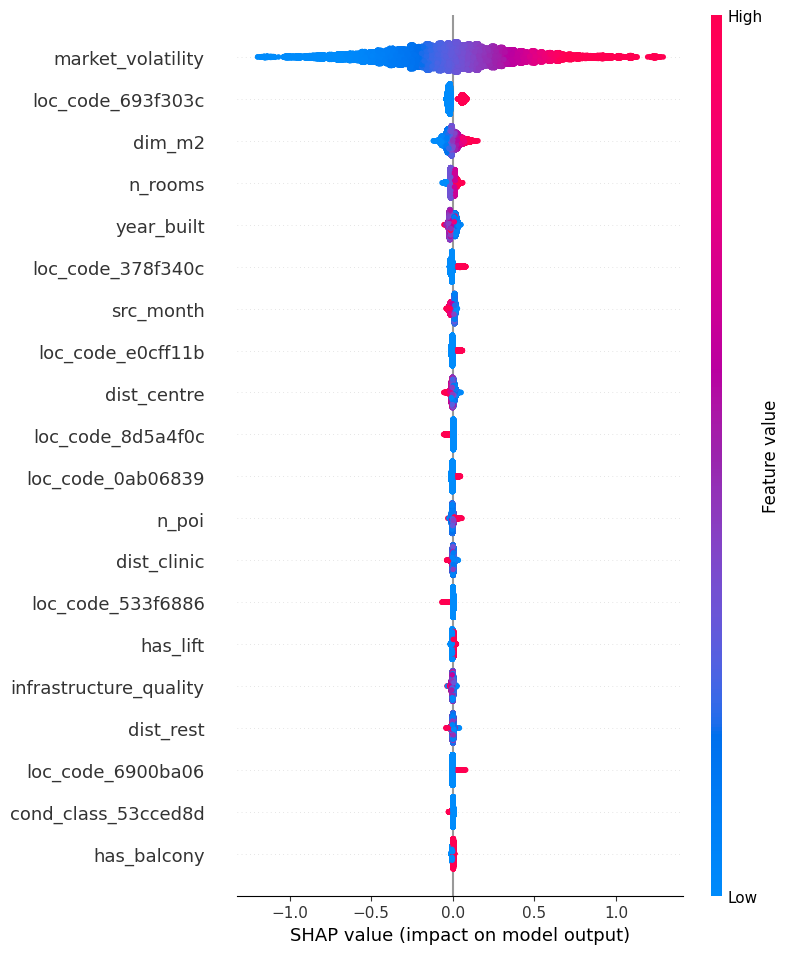

In [40]:
# Generate SHAP summary plot showing feature importance and impact direction
shap.summary_plot(
    shap_values,        
    features=x_test,      
    feature_names=x_test.columns
)

In [42]:
# Create SHAP values DataFrame and display feature importance ranking by mean absolute impact
shap_df = pd.DataFrame(data=shap_values.values, columns=x_test.columns)
mean_abs_shap_values = np.abs(shap_df).mean(axis=0).sort_values(ascending=False)
print("\nFeature importance (ranked by mean absolute SHAP value):")
print(mean_abs_shap_values)


Feature importance (ranked by mean absolute SHAP value):
market_volatility             0.317378
loc_code_693f303c             0.034784
dim_m2                        0.032930
n_rooms                       0.016587
year_built                    0.014411
loc_code_378f340c             0.014317
src_month                     0.010961
loc_code_e0cff11b             0.007841
dist_centre                   0.007704
loc_code_8d5a4f0c             0.005944
loc_code_0ab06839             0.005899
n_poi                         0.004785
dist_clinic                   0.004396
loc_code_533f6886             0.004395
has_lift                      0.004168
infrastructure_quality        0.004144
dist_rest                     0.003880
loc_code_6900ba06             0.003269
cond_class_53cced8d           0.003228
has_balcony                   0.003206
obj_type_2a6d5c01             0.003172
estimated_maintenance_cost    0.002879
obj_type_0d6c4dfc             0.002774
cond_class_a2881958           0.002730
loc_co

# 2. Ensemble Blending

In [43]:
# Import data
df_train, df_test = train_test_split(
    apartments_train,
    test_size=0.2,        
    random_state=476677,     
    shuffle=True
)

In [44]:
# Define the target variable column name
target = 'price_z'

x_train_bm, y_train_bm = df_train.drop(columns = target), df_train[target]


x_test,  y_test  = df_test.drop(columns = target),  df_test[target]

In [45]:
numeric = ['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post', 'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'market_volatility', 'infrastructure_quality', 'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio', 'estimated_maintenance_cost', 'global_economic_index']
categorical = ['obj_type', 'own_type', 'build_mat', 'cond_class', 'loc_code']
boolean = ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']
datetime = ['src_month','year_built']

In [46]:
preprocess_pipe = Pipeline([
    ("prep", CustomPreprocessor(    
        numeric=numeric,           
        categorical=categorical,  
        boolean=boolean,          
        date_col='src_month',     
        year_col='year_built' )),
    ("time", time_pipeline),
])

In [47]:
x_train_bm = preprocess_pipe.fit_transform(x_train_bm, y_train_bm)

C:\Users\JasmineJiang\AppData\Local\Temp\ipykernel_13648\1660848251.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[:, 'src_month'] = pd.NaT  # Initialize with NaT


In [48]:
x_test = preprocess_pipe.transform(x_test)

C:\Users\JasmineJiang\AppData\Local\Temp\ipykernel_13648\1660848251.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[:, 'src_month'] = pd.NaT  # Initialize with NaT


In [49]:
x_train_bm.dtypes

dim_m2                        float64
n_rooms                       float64
floor_no                      float64
floor_max                     float64
year_built                    Float64
dist_centre                   float64
n_poi                         float64
dist_sch                      float64
dist_clinic                   float64
dist_post                     float64
dist_kind                     float64
dist_rest                     float64
dist_uni                      float64
dist_pharma                   float64
has_park                         int8
has_balcony                      int8
has_lift                         int8
has_sec                          int8
has_store                        int8
src_month                     Float64
market_volatility             float64
infrastructure_quality        float64
neighborhood_crime_rate       float64
popularity_index              float64
green_space_ratio             float64
estimated_maintenance_cost    float64
global_econo

In [50]:
df_display(x_train_bm.head())

,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,dist_post,dist_kind,dist_rest,dist_uni,dist_pharma,has_park,has_balcony,has_lift,has_sec,has_store,src_month,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index,obj_type_0c238f18,obj_type_0d6c4dfc,obj_type_2a6d5c01,obj_type_missing,own_type_12631efb,own_type_4e625087,own_type_bfb8fe10,build_mat_7ceffe3b,build_mat_7f8c00f9,build_mat_missing,cond_class_53cced8d,cond_class_a2881958,cond_class_missing,loc_code_0ab06839,loc_code_143768f7,loc_code_378f340c,loc_code_3cb4aaff,loc_code_533f6886,loc_code_570cb745,loc_code_64a58667,loc_code_6900ba06,loc_code_693f303c,loc_code_765f79ed,loc_code_81b10147,loc_code_8d5a4f0c,loc_code_a6d54bd1,loc_code_e0cff11b,loc_code_ece39f3d
68072,37.91,2.00,3.00,4.00,137.00,0.79,117.00,0.07,0.74,0.15,0.27,0.02,0.43,0.12,0,1,0,0,1,7.00,798229.35,132.96,53.92,55.14,1.00,12.64,96.22,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
131416,51.91,3.00,1.00,4.00,0.00,5.04,4.00,1.33,2.88,0.59,0.13,0.38,1.80,0.39,0,0,0,0,0,3.00,487377.17,0.00,61.90,41.89,1.00,21.77,104.57,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
76111,58.91,3.00,7.00,10.00,54.00,5.21,30.00,0.16,0.13,0.33,0.14,0.08,1.75,0.02,0,1,1,0,0,8.00,481812.31,77.06,99.06,41.91,1.00,15.49,92.40,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
61260,57.56,3.00,2.27,3.00,18.00,6.24,2.00,0.90,3.55,0.69,0.73,0.51,2.22,0.40,1,0,0,0,0,1.00,1038592.06,18.10,51.03,66.94,1.00,18.66,100.58,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
25598,59.97,3.00,2.00,4.00,68.00,0.91,43.00,0.14,0.12,0.18,0.33,0.07,0.08,0.04,1,0,0,0,1,2.00,699708.59,95.06,16.95,64.74,1.00,14.91,91.82,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [51]:
x_train_bm.columns

Index(['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built',
       'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post',
       'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'has_park',
       'has_balcony', 'has_lift', 'has_sec', 'has_store', 'src_month',
       'market_volatility', 'infrastructure_quality',
       'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio',
       'estimated_maintenance_cost', 'global_economic_index',
       'obj_type_0c238f18', 'obj_type_0d6c4dfc', 'obj_type_2a6d5c01',
       'obj_type_missing', 'own_type_12631efb', 'own_type_4e625087',
       'own_type_bfb8fe10', 'build_mat_7ceffe3b', 'build_mat_7f8c00f9',
       'build_mat_missing', 'cond_class_53cced8d', 'cond_class_a2881958',
       'cond_class_missing', 'loc_code_0ab06839', 'loc_code_143768f7',
       'loc_code_378f340c', 'loc_code_3cb4aaff', 'loc_code_533f6886',
       'loc_code_570cb745', 'loc_code_64a58667', 'loc_code_6900ba06',
       'loc_code_693f303c', 'loc

In [52]:
check_missing_data(x_train_bm)

,dtype,count,missing,missing_%


In [53]:
estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb_pipe)
]

In [54]:
final_estimator = Lasso()

In [55]:
# Build Stacking model
# cv=5 indicates using 5-fold cross-validation to generate meta-model training data
# passthrough=False means only base models' predictions will be used as meta-model inputs
# If set to True, original features will be concatenated with predictions as meta-model inputs
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

# Train the model
print("Training Stacking model...")
stacking_regressor.fit(x_train_bm, y_train_bm)
print("Training completed!")

Training Stacking model...
Training completed!


d:\Anaconda\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.385e+14, tolerance: 2.324e+12
  model = cd_fast.enet_coordinate_descent(


In [56]:
# Generate predictions
y_pred = stacking_regressor.predict(x_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Stacking Model RMSE: {rmse:.4f}")

Stacking Model RMSE: 92887.8194
